# Inverse Compton Scattering

At the low energy limit, Tracy calculated an approximate expression for dN/(dt deps1), which is the number of photons per scattered energy eps1 per unit time. This expression is presented as an integrand, integrated over the CMB spectrum.

In [1]:
%load_ext autoreload

In [104]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle

from astropy.io import fits

import darkhistory.physics as phys
import darkhistory.spec.spectrum as spec
import darkhistory.spec.transferfunction as tf
from darkhistory.electrons.ics.ics_spectrum import ics_spec

In [3]:
nonrel_ICS_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
nonrel_ICS_table = np.array(nonrel_ICS_table, dtype='float64')
rel_ICS_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
rel_ICS_table = np.array(rel_ICS_table, dtype='float64')
rel_ICS_upp_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel_upp.raw","rb"))
rel_ICS_upp_table = np.array(rel_ICS_upp_table, dtype='float64')

engloss_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))
engloss_table = np.array(engloss_table, dtype='float64')


In [4]:
nEe = 5000
nEp  = 5000

Emax_nonrel = 1e10
Emin_nonrel = 1e-8

dlnEp = np.log(Emax_nonrel/Emin_nonrel)/nEp
lowengEp_nonrel = Emin_nonrel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_nonrel/Emin_nonrel)/nEe
lowengEe_nonrel = phys.me + Emin_nonrel*np.exp((np.arange(nEe)+0.5)*dlnEe)

Emax_rel = 1e20
Emin_rel = 1e-8

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp_rel = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe_rel = Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

Emax = 1e10
Emin = 1e-8
nEe = 400
nEp  = 400

dlnEp = np.log(Emax/Emin)/nEp
delta_engloss = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_engloss = phys.me + Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

`nonrel_ICS` and `engloss` both have `in_eng` given by *kinetic energy* of the electron. This allows for good logarithmic interpolation where necessary. `rel_ICS` reads in the *total energy* of the electron, but this doesn't always correspond to a physical quantity, due to the mathematical trick we make use of to move from one temperature to another.

In [5]:
nonrel_ICS = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_nonrel, ICS_array, 1000) for ICS_array in nonrel_ICS_table],
    in_eng=lowengEe_nonrel-phys.me, dlnz=1
)

rel_ICS = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_rel, ICS_array, 1000) for ICS_array in rel_ICS_table],
    in_eng=lowengEe_rel, dlnz=1
)

rel_ICS_upp = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_rel, ICS_array, 1000) for ICS_array in rel_ICS_upp_table],
    in_eng=lowengEe_rel, dlnz=1
)

engloss = tf.TransFuncAtRedshift(
    [spec.Spectrum(delta_engloss, ICS_array, 1000) for ICS_array in engloss_table],
    in_eng=lowengEe_engloss-phys.me, dlnz=1
)

In [6]:
file_name_nonrel = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/thomsontable.fits"
file_nonrel = fits.open(file_name_nonrel)
file_name_rel = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/kntable.fits"
file_rel = fits.open(file_name_rel)
file_name_engloss = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/thomson_engloss_table_fixed.fits"
file_engloss = fits.open(file_name_engloss)


In [44]:
lowengEp_file_nonrel = file_nonrel[1].data[0][0]
lowengEe_file_nonrel = file_nonrel[1].data[0][1]
lowengEp_file_rel = file_rel[1].data[0][0]
lowengEe_file_rel = file_rel[1].data[0][1]
lowengEp_file_engloss = file_engloss[1].data[0][0]
lowengEe_file_engloss = file_engloss[1].data[0][1]

nonrelspec_file = np.array(file_nonrel[1].data[0][2])
nonrel_ICS_file = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_nonrel, ICS_array, 1000) for ICS_array in nonrelspec_file],
    in_eng=lowengEe_file_nonrel-510998.903, dlnz=1
)
relspec_file = np.array(file_rel[1].data[0][2])
rel_ICS_file = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_rel, ICS_array, 1000) for ICS_array in relspec_file],
    in_eng=lowengEe_file_rel, dlnz=1
)
englossspec_file = np.array(file_engloss[1].data[0][2])
engloss_file = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_engloss, ICS_array, 1000) for ICS_array in englossspec_file], 
    in_eng = lowengEe_file_engloss-510998.903, dlnz=1
)

In [8]:
lowengEe_file_nonrel-510998.903

array([  1.00699253e-08,   1.01281330e-08,   1.01863407e-08, ...,
         9.79489985e+09,   9.87643023e+09,   9.95863924e+09])

[0.0001, 1000000000000.0, 1e-18, 1]

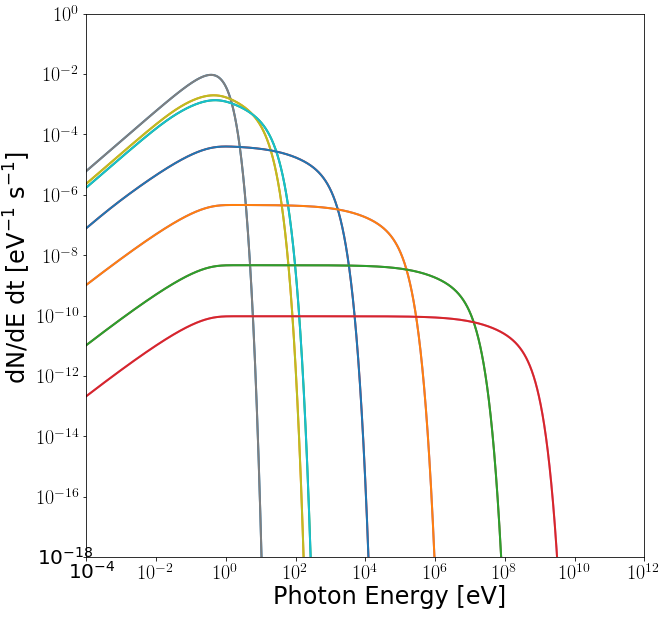

In [9]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([2e-8, 7e5, 1e6, 1e7, 1e8, 1e9, 7e9])

nonrel_ICS.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
nonrel_ICS_file.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e12, 1e-18, 1])


[1e-08, 1e+20, 1e-30, 1e+20]

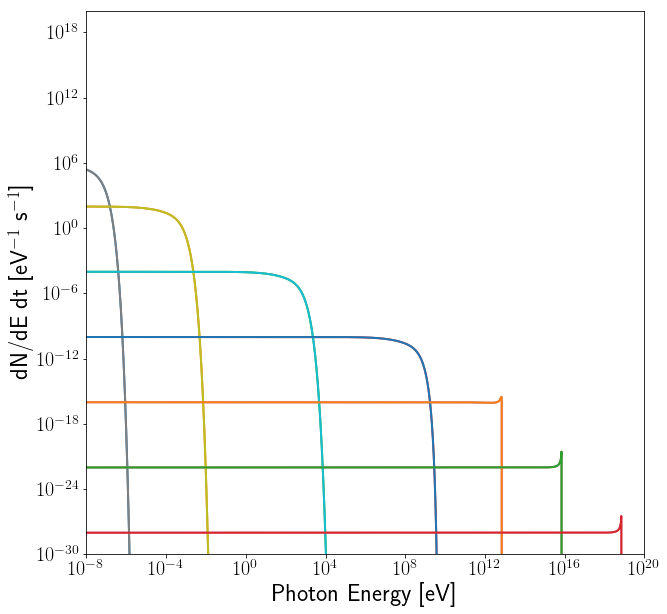

In [68]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([7e1, 7e3, 7e6, 7e9, 7e12, 7e15, 7e18])

rel_ICS.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
# rel_ICS_upp.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
rel_ICS_file.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e20])

[1e-08, 1e+20, 1e-30, 1e+20]

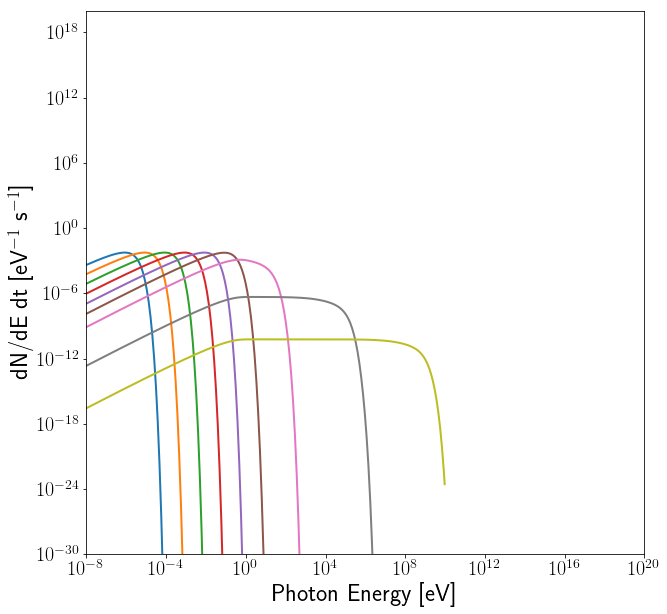

In [11]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8, 9e9])

engloss.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
# engloss_file.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e20])

In [105]:
%%prun
nEe = 500
nEp = 500

Emax_rel = 1e20
Emin_rel = 1e-8

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe = phys.me + Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

# b = ics_spec(lowengEe, lowengEp, phys.TCMB(100))
c = ics_spec(lowengEe, lowengEp, phys.TCMB(100), 
             nonrel_tf=nonrel_ICS_file, rel_tf=rel_ICS_file)

[1e-08, 1e+20, 1e-30, 1e-06]

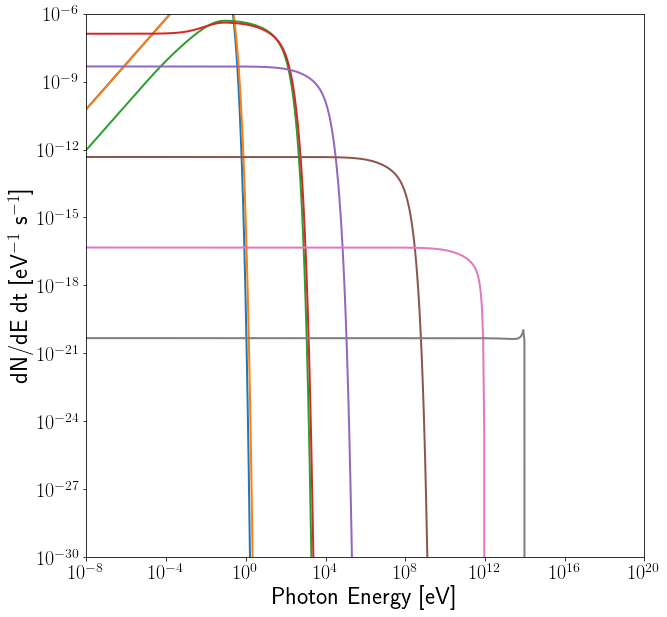

In [102]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_kineng = np.array([1e-4, 1e4, 9e6, 1e7, 1e8, 1e10, 1e12, 1e14])

b.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
# c.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e-6])

[1e-08, 1e+20, 1e-30, 1e+20]

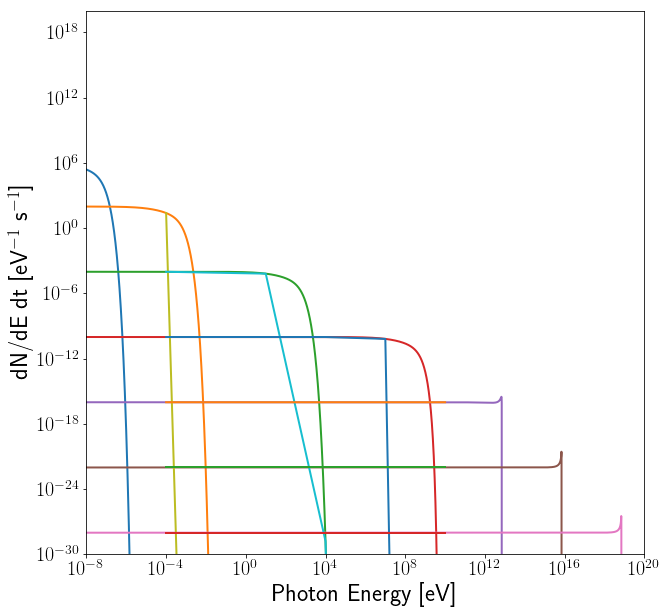

In [80]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([7e1, 7e3, 7e6, 7e9, 7e12, 7e15, 7e18])

rel_ICS_file.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
test = rel_ICS_file.at_eng(np.array([1e-4, 1e1, 1e4, 1e7, 1e10]))
test.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e20])